In the previous notebook we set up a HMM and forward computing process. This one will extend that idea, with a few differences. 

In [26]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [13]:
# experimenting with torch
# unsqueeze function
x = torch.tensor([1, 2, 3, 4])
c = torch.unsqueeze(x, 0)  # adds a dimension at index 0
print(c)
b = torch.unsqueeze(x, 1)  # adds a dimension at index 1
print(b)

       # Hidden State Ha   Hb    Hc
transition_matrix = torch.tensor([[0.9,0.05,0.05],
                     [0.05,0.9,0.05],
                     [0.05,0.05,0.9]])

       # emissions  # A   B    C
emission_matrix = torch.tensor([[0.9,0.05,0.05],
                     [0.05,0.9,0.05],
                     [0.05,0.05,0.9]])


pi = torch.tensor([0.3,0.4,0.3])

eta = torch.tensor([0.9,0.05,0.05])

tensor([[1, 2, 3, 4]])
tensor([[1],
        [2],
        [3],
        [4]])


Now imagine the state and symbols are mixed into a single matrix. Design this matrix M to be able to update once every transition, that transform the current mixed state to a linear combination of it, which is the updated mixed state. Because M already inform us about the probability distribution, the update should include the symbol, and we choose one of the three msp matrix to update the probability. 

In [23]:
def compute_msp_matrices(A: torch.Tensor, B: torch.Tensor):
    """
    Given HMM transition matrix A [N, N] and emission matrix B [N, M],
    return a list of MSP matrices T_k, one for each observation symbol k.
    """
    N, M = B.shape
    T_list = []
    
    for k in range(M):  # loop over observation symbols
        emission_col = B[:, k]                      # shape (N,)
        T_k = A * emission_col.unsqueeze(0)         # broadcast multiply to shape (N, N)
        T_list.append(T_k)
    print("T_list:", T_list)
    return T_list  # list of [N x N] tensors, each is T_k

def generate_store_token_belief(T_list,pi:torch.tensor,eta,cycle,seed=None):
     token = []
     belief = []
     store = []
     eta = eta
     print("pi:", pi.shape[0])
     if seed is not None:
          torch.manual_seed(seed)
     for _ in range(cycle):
          dice = np.random.choice(pi.shape[0])
          print("dice:", dice)
          t_x = T_list[dice]
          
          eta = eta @ t_x
          eta = eta / eta.sum()
          
          token.append(pi[dice])
          belief.append(eta)
          store.append(get_cartesian_from_barycentric(eta))
     return token,belief,store

# helper function
def get_cartesian_from_barycentric(b):
    t = np.transpose(np.array([[0,0],[1,0],[0.5, np.sqrt(3)/2]])) # Triangle
    return t.dot(b)

print(get_cartesian_from_barycentric(eta))
          


[0.075      0.04330127]


In [27]:
t_list = compute_msp_matrices(transition_matrix, emission_matrix)
tokens, beliefs,store = generate_store_token_belief(t_list, pi=pi,eta=eta, cycle=1000)

T_list: [tensor([[0.8100, 0.0025, 0.0025],
        [0.0450, 0.0450, 0.0025],
        [0.0450, 0.0025, 0.0450]]), tensor([[0.0450, 0.0450, 0.0025],
        [0.0025, 0.8100, 0.0025],
        [0.0025, 0.0450, 0.0450]]), tensor([[0.0450, 0.0025, 0.0450],
        [0.0025, 0.0450, 0.0450],
        [0.0025, 0.0025, 0.8100]])]
pi: 3
dice: 1
dice: 1
dice: 2
dice: 2
dice: 2
dice: 1
dice: 0
dice: 1
dice: 0
dice: 1
dice: 1
dice: 2
dice: 1
dice: 2
dice: 0
dice: 0
dice: 2
dice: 0
dice: 2
dice: 1
dice: 2
dice: 1
dice: 0
dice: 0
dice: 1
dice: 2
dice: 2
dice: 2
dice: 2
dice: 1
dice: 2
dice: 0
dice: 0
dice: 0
dice: 1
dice: 0
dice: 0
dice: 2
dice: 1
dice: 2
dice: 0
dice: 2
dice: 0
dice: 1
dice: 2
dice: 0
dice: 1
dice: 1
dice: 0
dice: 2
dice: 1
dice: 1
dice: 2
dice: 1
dice: 2
dice: 1
dice: 2
dice: 0
dice: 0
dice: 1
dice: 2
dice: 1
dice: 2
dice: 0
dice: 1
dice: 0
dice: 1
dice: 1
dice: 2
dice: 2
dice: 1
dice: 1
dice: 0
dice: 1
dice: 2
dice: 2
dice: 2
dice: 0
dice: 0
dice: 0
dice: 0
dice: 0
dice: 0
dice: 0
d

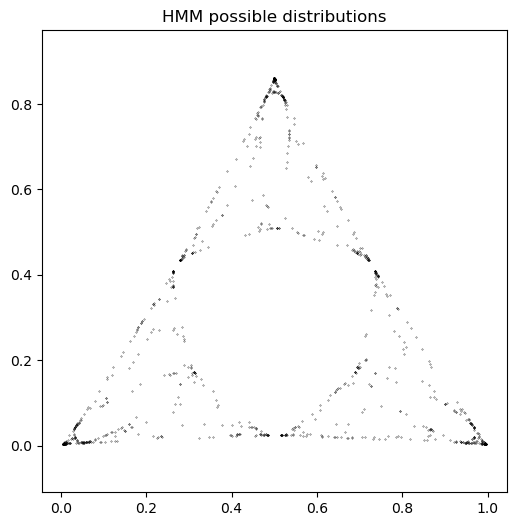

In [28]:
#ploting
store = np.array(store)
plt.figure(figsize=(6, 6))
plt.plot(store[:, 0], store[:, 1], 'k.', markersize=0.5)
plt.axis('equal')
plt.title("HMM possible distributions")
plt.show()